# Preload libraries and functions
First of all, let's import libraries that will be used in this example

In [19]:
# clear all variants
# %reset -f   

# Autoreload the customize modules.
%reload_ext autoreload
# Or load_ext autoreload for the first run
# %aimport
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time, os


# import tensorflow as tf
# from tensorflow import keras

import HackModules.HackClasses as hc
import HackModules.HackFunctions as hf
from HackModules.progressMonitor import progressBar
from HackModules.progressMonitor import timer

#matplot inline
# np.set_printoptions(precision=8)

# help(hc) # To test the docstrings ((TBDBS To be deleted before submission))

# Alternative customize module import method
# import sys, os
# sys.path.append(os.getcwd()+'/HackModules/') # add /HackModules to the path
# import HackClasses as hc


Define some seldom used functions and class

# Data Import and Initialization

In [4]:
df = pd.read_excel('obs_data_w.xlsx', sheet_name=0) #sheet_name='Sheet1')
print(df)

         V    T  uncertainty             J
0     0.00  100     0.001000  0.000000e+00
1     0.05  100     0.001000  6.417136e-90
2     0.10  100     0.001000  1.081096e-88
3     0.15  100     0.001000  1.719633e-87
4     0.20  100     0.001000  2.725747e-86
5     0.25  100     0.001000  4.319561e-85
6     0.30  100     0.001000  6.845225e-84
7     0.35  100     0.001000  1.084764e-82
8     0.40  100     0.001000  1.719028e-81
9     0.45  100     0.001000  2.724148e-80
10    0.50  100     0.001000  4.316963e-79
11    0.55  100     0.001000  6.841100e-78
12    0.60  100     0.001000  1.084111e-76
13    0.65  100     0.001000  1.717992e-75
14    0.70  100     0.001000  2.722506e-74
15    0.75  100     0.001000  4.314361e-73
16    0.80  100     0.001000  6.836977e-72
17    0.85  100     0.001000  1.083457e-70
18    0.90  100     0.001000  1.716957e-69
19    0.95  100     0.001000  2.720865e-68
20    1.00  100     0.001000  4.311761e-67
21    1.05  100     0.001000  6.832857e-66
22    1.10 

## Train, cross validation and test data

### Random Method 1: Sample function of df

In [23]:
tcv=df.sample(frac=0.8) # random_state=200
test=df.drop(tcv.index)
test=test.sample(frac=1) # shuffle the rows

print(test.shape)

(1579, 4)


### Random Method 2: random array

In [ ]:
# idx=np.arange(0,len(df))
# np.random.shuffle(idx)
# temp_split=math.floor(0.8*len(df))
# #idx[0:20]
# train=df.iloc[idx[0:temp_split],:]
# test=df.iloc[idx[temp_split:],:] # Output all the elements after temp_split
# print(train.shape)
# print(test.shape)

## Split test data into data and results, add polynominal features and normalize them.

In [38]:
test_data=test.loc[:,['V','T']]
test_unc=test.uncertainty.values
test_J=test.J.values

degree = 2
test_data=hc.data(test_data,degree=degree,method='std')

print(f'The polynominal degree is {degree}.\n')
print('Polynominal test data = \n', test_data.poly, '\n')
print('Normalized test_data = \n', test_data.norm, '\n')

The polynominal degree is 2.

Polynominal test data = 
 [[0.00000e+00 1.41000e+02 0.00000e+00 0.00000e+00 1.98810e+04]
 [2.50000e-01 1.11000e+02 6.25000e-02 2.77500e+01 1.23210e+04]
 [1.65000e+00 1.22000e+02 2.72250e+00 2.01300e+02 1.48840e+04]
 ...
 [3.55000e+00 1.08000e+02 1.26025e+01 3.83400e+02 1.16640e+04]
 [2.10000e+00 1.80000e+02 4.41000e+00 3.78000e+02 3.24000e+04]
 [2.70000e+00 1.27000e+02 7.29000e+00 3.42900e+02 1.61290e+04]] 

Normalized test_data = 
 [[ 1.         -1.63181629 -0.35273076 -1.05760725 -1.55211863 -0.32247535]
 [ 1.         -1.39560952 -0.59369376 -1.04149734 -1.40069518 -0.40424894]
 [ 1.         -0.07285161 -0.50534066 -0.35585976 -0.45368476 -0.37652596]
 ...
 [ 1.          1.72231983 -0.61779006  2.19079413  0.53998046 -0.41135546]
 [ 1.          0.35232057 -0.03947887  0.0791077   0.51051427 -0.18706216]
 [ 1.          0.91921682 -0.46518016  0.82145215  0.31898408 -0.36305928]] 



# Model Training

## Method 1: Normal Equation

### Training with regulation

### Example to find best regulation coefficient

Progress: |██████████████████████████████████████████████████| 100.00% Complete     Run: 00:04:46; Left: 00:00:00 (Total: 00:04:46)

The time cost is 00:04:46
The paramters are:
	beta_num = 10
	epoch = 100
The values of beta with various regulation coefficients and different training samples are:
[0.15811388 0.19525122 0.15811388 0.15811388 0.00188309 0.4540344
 0.06799469 0.08396509 0.06799469 0.00540742]
The value of BETA should be  0.13508722452970817


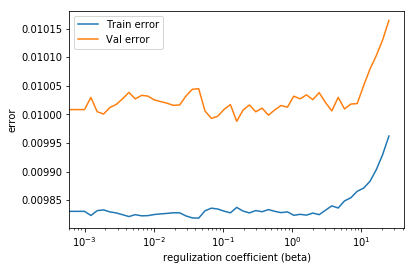

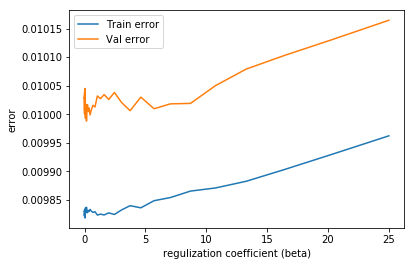

In [34]:
beta_range=np.geomspace(0.001,25, num = 50-1, endpoint = True, dtype=np.float64)
beta_range=np.insert(beta_range,0,0) # insert a zero element in the first index
beta_num=10
epoch   =100

# Calculate the beta array
t_start=time.time()
beta_array, error_train_reg, error_cv_reg=hf.beta_loop(tcv, beta_num, epoch, beta_range=beta_range, degree=2, 
                                                       rep=True, multiprocess='OFF', cpu_num=4)
t_end=time.time()
print(f'\nThe time cost is {hf.formatTime(t_end-t_start)}',end='\n')

print(f'The paramters are:\n\tbeta_num = {beta_num}\n\tepoch = {epoch}')
print(f'The values of beta with various regulation coefficients and '+ 
      f'different training samples are:\n{beta_array}')

print('The value of BETA should be ', beta_array.mean())
# print('The test error with best THETA and BETA is ', error_test_reg)

# log-scale plot error vs. beta
plt.figure()
plt.semilogx(beta_range, error_train_reg, label = 'Train error')
plt.semilogx(beta_range, error_cv_reg, label = 'Val error')
plt.xlabel('regulization coefficient (beta)')
plt.ylabel('error')
plt.legend()

# plot error vs. beta
plt.figure()
plt.plot(beta_range, error_train_reg, label = 'Train error')
plt.plot(beta_range, error_cv_reg, label = 'Val error')
plt.xlabel('regulization coefficient (beta)')
plt.ylabel('error')
plt.legend()

### Find the best poly degree and regulation coefficient

In [ ]:
degree_range=list(range(1,5))
# featureSize=test_data.norm.shape[1]
beta_range=np.geomspace(0.001,50, num = 50-1, endpoint = True, dtype=np.float64)
beta_range=np.insert(beta_range,0,0) # insert a zero element in the first index
                      

# Calculate the beta array
t_start=time.time()
beta_array, error_train_reg, error_cv_reg=hf.beta_loop(tcv, beta_num=10, epoch=100, beta_range=beta_range, degree=2, 
                                                       rep=True, multiprocess='OFF', cpu_num=4)
t_end=time.time()
print(f'\nThe time cost is {hf.formatTime(t_end-t_start)}',end='\n')

print(f'The mean value of beta with various regulation coefficients and'+ 
      f'different training samples are:\n{beta_array}')

print('The value of BETA should be ', beta_array.mean())
# print('The test error with best THETA and BETA is ', error_test_reg)

# log-scale plot error vs. beta
plt.figure()
plt.semilogx(beta_range, error_train_reg, label = 'Train error')
plt.semilogx(beta_range, error_cv_reg, label = 'Val error')
plt.xlabel('regulization coefficient (beta)')
plt.ylabel('error')
plt.legend()

# plot error vs. beta
plt.figure()
plt.plot(beta_range, error_train_reg, label = 'Train error')
plt.plot(beta_range, error_cv_reg, label = 'Val error')
plt.xlabel('regulization coefficient (beta)')
plt.ylabel('error')
plt.legend()

# Prediction

In [50]:
beta_array.mean()

1.5102402949001281

In [80]:
len(beta_range)

50

In [30]:
print(f'The paramters are:\nbeta_num = {beta_num}\nepoch = {epoch}')

NameError: name 'beta_num' is not defined

In [ ]:
t.polyFeature(2)
t.array.shape

In [ ]:
type(theta_reg)

In [54]:
list(range(1,5))

[1, 2, 3, 4]

In [18]:
os.cpu_count()

64